In [57]:
from PIL import Image
import json
import numpy as np
import matplotlib.pyplot as plt
import os

Getting pixels of an image

In [3]:
with open('metadata.json') as f:
    coords = json.load(f)

In [109]:
image_name = "42.637205_2.8694305.png"
im = Image.open(f"images/{image_name}", "r")

In [15]:
def get_pixels_range(bounds_x_y):
    min_x = 512
    max_x = 0
    min_y = 512
    max_y = 0

    for coords in bounds_x_y:
        if coords["x"] > max_x: max_x = coords["x"]
        if coords["x"] < min_x: min_x = coords["x"]
        if coords["y"] > max_y: max_y = coords["y"]
        if coords["y"] < min_y: min_y = coords["y"]

    return [int(x) for x in [np.floor(min_x), np.ceil(max_x), np.floor(min_y), np.ceil(max_y)]]
    

### Images processing

The idea is to generate a dataset with images that are pools by using the metadata.json file and images that are not pools, train a CNN and, in order to find the pools in new data, iterate over an image and get the subimage with the highest probability of being a pool. So given that the rectangles have different pixels sizes, for simplicity, I need the biggest rectangle so all the subimages will be cropped with the same size. This will be done based on the json file.

In [37]:
filenames = list(coords.keys())
image_names = os.listdir("images")
print(f"There are {len(filenames) - len(image_names)} objects in the json without image")

In [94]:
# max_width = 0
# max_height = 0
widths = []
heights = []

for filename in [el for el in filenames if el not in ["42.677504_2.6868817.png", "42.7004154_3.0166456.png"]]:
    min_x, max_x, min_y,max_y = get_pixels_range(coords[filename]["bounds_x_y"])
    im_width = max_x - min_x
    im_height = max_y - min_y
    widths.append(im_width)
    heights.append(im_height)
    # if im_width > max_width:
    #     max_width = im_width
    #     new = filename
    # if im_height > max_height:
    #     max_height = im_height
    #     other = filename
        
# print(f"Max width is {max_width}. Max height is {max_height}")

Max width is 0. Max height is 0


The problem is that there are some images where the pool is really big, so it will be considered an outlier. Since the image is 512x512. By choosing image size of 100 is almost taking into account 90% of the images we have

Text(85, -10, '0.25: 62.0\n0.50: 77.0\n0.95: 114.0')

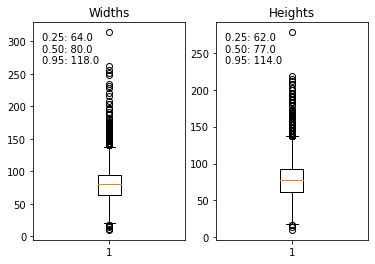

In [128]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
plt.boxplot(widths)
plt.title('Widths')
plt.annotate(f"0.25: {np.percentile(widths, 25)}\n0.50: {np.percentile(widths,50)}\n0.95: {np.percentile(widths, 95)}",
xy=(0, 1), xycoords=("data", 'axes fraction'),
                    xytext=(85, -10), textcoords='offset points',
                    ha="left", va="top"
)
ax1 = fig.add_subplot(1,2,2)
plt.boxplot(heights)
plt.title('Heights')
plt.annotate(f"0.25: {np.percentile(heights, 25)}\n0.50: {np.percentile(heights,50)}\n0.95: {np.percentile(heights, 95)}",
xy=(0, 1), xycoords=("data", 'axes fraction'),
                    xytext=(85, -10), textcoords='offset points',
                    ha="left", va="top"
)

In [138]:
xAxis = [el["x"] for el in coords[filenames[100]]["bounds_x_y"]]
yAxis = [512 - el["y"] for el in coords[filenames[100]]["bounds_x_y"]]
plt.scatter(xAxis, yAxis)
plt.xlabel("x coords")
plt.ylabel("y coords")
plt.show()

In [146]:
min_x, max_x, min_y,max_y = get_pixels_range(coords[filenames[123]]["bounds_x_y"])

im = Image.open(f"images/{filenames[123]}")
im.show()

pixels = im.load()

all_pixels = []
for height in range(min_y,max_y):
    for width in range(min_x, max_x):
        cpixel = pixels[width, height]
        all_pixels.append(cpixel)

img = Image.new('RGB', (max_x-min_x,max_y-min_y))
img.putdata(all_pixels)
img.show()
img.save(f"cropped_images/{filenames[123]}")


(eog:274210): EOG-CRITICAL **: 18:52:00.334: eog_image_get_file: assertion 'EOG_IS_IMAGE (img)' failed

(eog:274210): GLib-GIO-CRITICAL **: 18:52:00.334: g_file_equal: assertion 'G_IS_FILE (file1)' failed


In [137]:
min_x, max_x, min_y,max_y, max_x-min_x,max_y-min_y

(196, 316, 198, 286, 120, 88)

In [150]:
def get_pixels(min_y,max_y,min_x, max_x, pixels):
    all_pixels = []
    for height in range(min_y,max_y):
        for width in range(min_x, max_x):
            cpixel = pixels[width, height]
            all_pixels.append(cpixel)
    
    return all_pixels


The next step is to crop the image and save it in the class_a folder and crop four images (for the moment) a save them in class_b folder. It is four images for each side of the pool (one above, one below, one left and one right)

In [222]:
for filename in filenames:
    
    min_x, max_x, min_y, max_y = get_pixels_range(
        coords[filename]["bounds_x_y"])
    im_width = max_x - min_x
    im_height = max_y - min_y

    if im_width < 101 and im_height < 101:
        center_x, center_y = (int(np.ceil((max_x + min_x)/2)),
                              int(np.ceil((max_y + min_y)/2)))
        try:
            im = Image.open(f"images/{filename}")
        except FileNotFoundError:
            continue
        pixels = im.load()

        all_pixels = get_pixels(center_y-50, center_y+50,
                                center_x - 50, center_x + 50, pixels)

        img = Image.new('RGB', (100, 100))
        img.putdata(all_pixels)
        img.save(f"cropped_images/class_a/{filename}")

        ix = 1
        for extra_x, extra_y in [(-100,0),(0,-100),(100,0),(0,100)]:
            all_pixels = get_pixels(center_y-50 + extra_y, center_y+50 + extra_y,
                                center_x - 50 + extra_x, center_x + 50 + extra_x, pixels)
            
            img_n = Image.new('RGB', (100, 100))
            img_n.putdata(all_pixels)
            img_n.save(f"cropped_images/class_b/{ix}_{filename}")
            ix +=1

